In [1]:
# 解决Tensorflow 2.x 版本无法使用sequence_loss_by_example()函数的问题
# https://www.codenong.com/cs105424997/

import numpy as np
import sklearn.preprocessing
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow_core  import seq_loss

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#boston = load_boston()
#x = boston.data
#y = boston.target
data = pd.read_csv("kc_house_data.csv")
print(data.shape)

data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

x = data.drop("price",axis=1)   #Feature Matrix
y = data["price"]          #Target Variable

print('x:', x.shape)
print('y:', y.shape)

ss_x2 = sklearn.preprocessing.StandardScaler()
train_x2 = ss_x2.fit_transform(x)

ss_y2 = sklearn.preprocessing.StandardScaler()
train_y2 = ss_y2.fit_transform(y.values.reshape(-1, 1))

(21613, 21)
x: (21613, 18)
y: (21613,)


In [3]:
BATCH_START = 0 # 建立 batch data 時的index
TIME_STEPS = 10 # backpropagation through time 的 time steps
BATCH_SIZE = 30
INPUT_SIZE = 18 # sin數據輸出size
OUTPUT_SIZE = 1 # cos數據輸出size
CELL_SIZE = 100 # RNN的hidden unit size
LR = 0.006 #learning rate

def get_batch_boston():
    global train_x2, train_y2, BATCH_START, TIME_STEPS
    x_part1 = train_x2[BATCH_START : BATCH_START + TIME_STEPS * BATCH_SIZE]
    y_part1 = train_y2[BATCH_START : BATCH_START + TIME_STEPS * BATCH_SIZE]
    print('時間段=', BATCH_START, BATCH_START + TIME_STEPS * BATCH_SIZE)

    seq = x_part1.reshape((BATCH_SIZE, TIME_STEPS, INPUT_SIZE))
    res = y_part1.reshape((BATCH_SIZE, TIME_STEPS, 1))

    BATCH_START += TIME_STEPS

    # returned seq, res and xs: shape (batch, step, input)
    # np.newaxis 用來增加一個維度，變成三維，第三個維度用來存上一批樣本的狀態
    return [seq, res]

In [4]:
def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = npu.arange(BATCH_START, BATCH_START+TIME_STEPS * BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10 * np.pi)
    print('xs.shape=', xs.shape)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS

    # 畫圖
    plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], 'b--')
    plt.show()

    print('增加維度前:', seq.shape)
    print(seq[ :2])
    print('增加維度後:', seq[ :, :, np.newaxis].shape)
    print(seq[ :2])
    # returned seq, res and xs: shape(batch, step, input)
    # np.newaxis 用來增加一個維度，變成三維，第三個維度用來存上一批樣本的狀態
    return [seq[ :, :, np.newaxis], res[ :, :, np.newaxis], xs]

In [5]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        '''
        n_steps: 每批數值總共含多少時間刻度
        input_size: 輸入數值的維度
        output_size: 輸出數值的維度 如果是類似價格曲線的話 應該為1
        cell_size: cell的大小
        batch_size: 每批次訓練數值的數量
        '''
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size

        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs') #xs 有三個維度
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys') #xs 有三個維度

        with tf.variable_scope('in_hidden'):
            self.add_input_layer()

        with tf.variable_scope('LSTM_cell'):
            self.add_cell()

        with tf.variable_scope('out_hidden'):
            self.add_output_layer()

        with tf.name_scope('cost'):
            self.compute_cost()

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    # 增加一個輸入層
    def add_input_layer(self):
        # 1_in_x: (batch * n_step, in_size), 相當於把這個批次的樣本串到一個長度1000的時間線上，每批次50個樣本，每個樣本20時刻
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D') #-1 表示任意行數
        # ws(in_size, cell_size)
        ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs(cell_size, )
        bs_in = self._bias_variable([self.cell_size])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')

    # 多時刻的狀態疊加層
    def add_cell(self):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(self.cell_size, forget_bias = 1.0, state_is_tuple = True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype = tf.float32)
        # time_major = False 表示時間主線不是第一列batch
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(lstm_cell, self.l_in_y, initial_state =               self.cell_init_state, time_major = False)

    #增加一個輸出層
    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name = '2_2D')
        ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('wx_plus_b'):
            self.pred = tf.matmul(l_out_x, ws_out) + bs_out #預測結果

    def compute_cost(self):
        losses = seq_loss.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function = self.msr_error,
            name = 'losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name = 'losses_sum'),
                self.batch_size,
                name = 'average_cost'
            )
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, y_pre, y_target):
        return tf.square(tf.sub(y_pre, y_target))

    def msr_error(self, logits, labels):
        return tf.square(tf.subtract(logits, labels))

    def _weight_variable(self, shape, name = 'weights'):
        initializer = tf.random_normal_initializer(mean = 0., stddev = 1., )
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name = 'biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)


時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
125 cose:  0.1245
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
126 cose:  0.0858
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 490
127 cose:  0.0601
時間段= 0 300
時間段= 10 310
時間段= 20 320
時間段= 30 330
時間段= 40 340
時間段= 50 350
時間段= 60 360
時間段= 70 370
時間段= 80 380
時間段= 90 390
時間段= 100 400
時間段= 110 410
時間段= 120 420
時間段= 130 430
時間段= 140 440
時間段= 150 450
時間段= 160 460
時間段= 170 470
時間段= 180 480
時間段= 190 

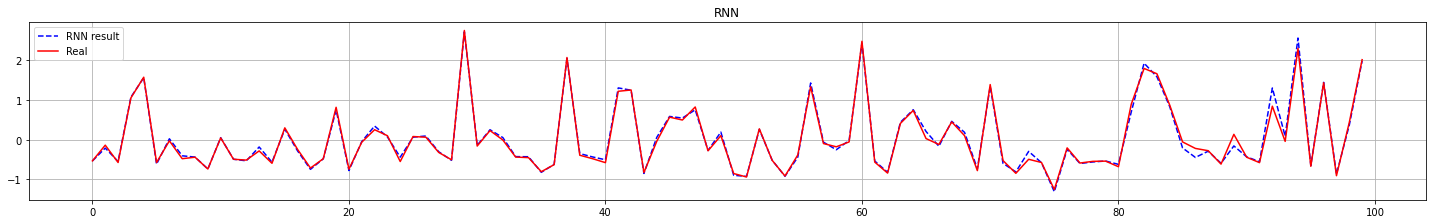

In [6]:
if __name__ == '__main__':
    seq, res = get_batch_boston()

    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True))
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    sess.run(tf.global_variables_initializer())

    # relocate to the local dir and run this line to view it on http://0.0.0.0:6006/
    #$tensorboard --logdir = 'logs'

    # 訓練200次
    for j in range(200):
        pred_res = None
        for i in range(20): #把整個數值分為20個時間段
            seq, res = get_batch_boston()

            if i == 0:
                feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    # create initial state
                }
            else:
                feed_dict = {
                    model.xs: seq,
                    model.ys: res,
                    model.cell_init_state: state
                    # use last state as the initial state for this run
                }

            _, cost, state, pred = sess.run(
                [model.train_op, model.cost, model.cell_final_state, model.pred],
                feed_dict = feed_dict
            )
            pred_res = pred
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)
        print('{0} cose: '.format(j ), round(cost, 4))
        BATCH_START = 0 # 從頭再來一遍

    # 畫圖
    print('result:', pred_res.shape)

    # 與最後一次訓練所用的數值保持一致
    train_y2 = train_y2[190: 490]
    print('實際', train_y2.flatten().shape)

    r_size = BATCH_SIZE * TIME_STEPS

    # 畫圖
    fig = plt.figure(figsize = (20, 3)) # dpi參數指定繪圖對象的分辨率，即每英吋多少個像素，缺省值為80
    axes = fig.add_subplot(1, 1, 1)
    # 為了方便看，只顯示了後100行數據
    line1, = axes.plot(range(100), pred.flatten()[-100:], 'b--', label = 'RNN result')
    #line2, = axes.plot(range(len(gbr_pridict)), gbr_pridict, 'r--', label = '優化參數')
    line3, = axes.plot(range(100), train_y2.flatten()[-100:], 'r', label = 'Real')

    axes.grid()
    fig.tight_layout()
    #plt.legend(handles = [line1, line2, line3])
    plt.legend(handles = [line1, line3])
    plt.title('RNN')
    plt.show()